In [1]:
import rfest

from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
%matplotlib inline

from rfest._utils import get_sdm

## Generate toy dataset

RFEst comes with a simple data generator. Here we generated a stimulus-response pair with a 3D Difference-of-Gaussian filter.

In [2]:
((X, Y), (Xtest, Ytest), 
 w_true) = rfest.make_data(dims=(15, 20, 5), sigma=(1.5, 1.5),
                           n_samples=2000, nsevar=1, 
                           filter_type='mexican_hat', seed=2046)
                          

### ASD

============0============
sigma: 4.472720967721436
rho: -2.3
delta: 1.0
cost: 147.26082101365168


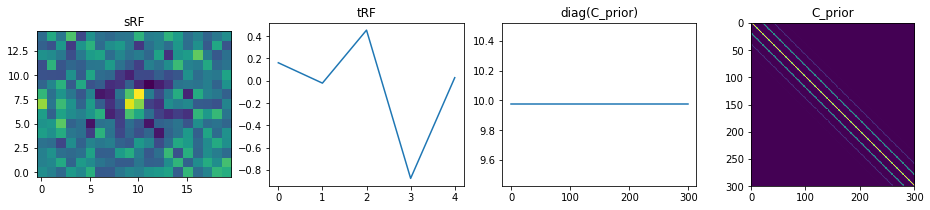

============500============
sigma: 3.9578493997145814
rho: -1.823776177124176
delta: 1.4946115736109882
cost: 132.58046354224462


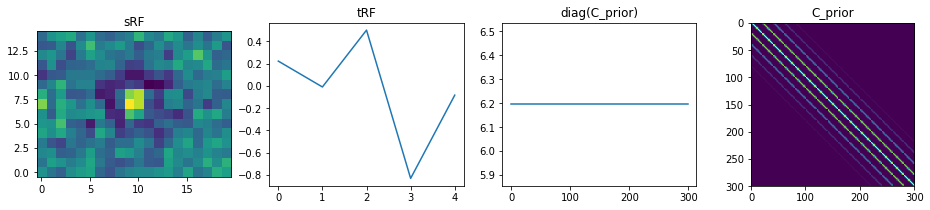

============1000============
sigma: 3.408871876288821
rho: -1.4228568770605927
delta: 1.8637076051426869
cost: 119.54740169958286


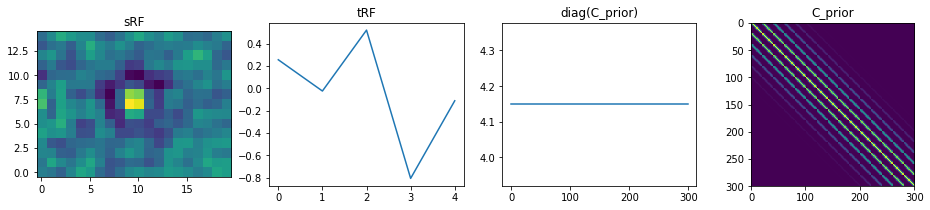

============1500============
sigma: 2.8471222273831986
rho: -1.0603129315966475
delta: 2.157383238396768
cost: 113.99444277454862


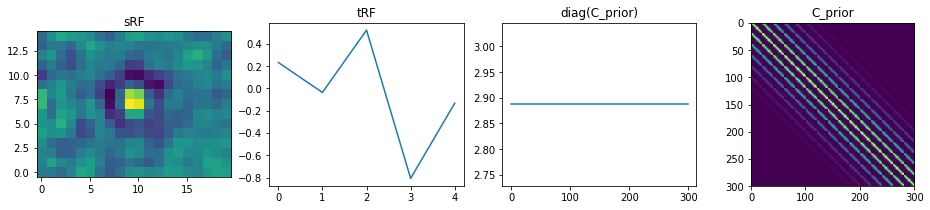

============2000============
sigma: 2.2914126255383604
rho: -0.8068093208805461
delta: 2.322719327965468
cost: 111.68925626587534


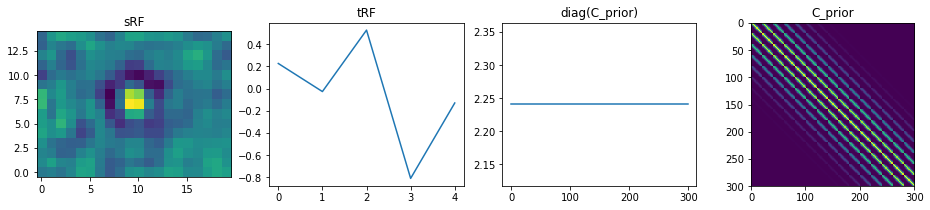

============2500============
sigma: 1.7843598276961543
rho: -0.8215660062329568
delta: 2.314063198714422
cost: 112.34929992230553


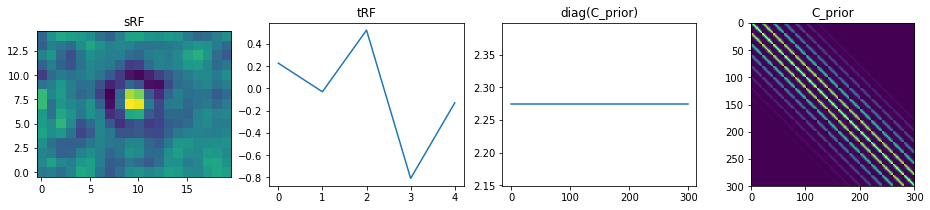

============3000============
sigma: 1.4090794754856895
rho: -0.8133180129889734
delta: 2.3634607916089587
cost: 112.20383954637175


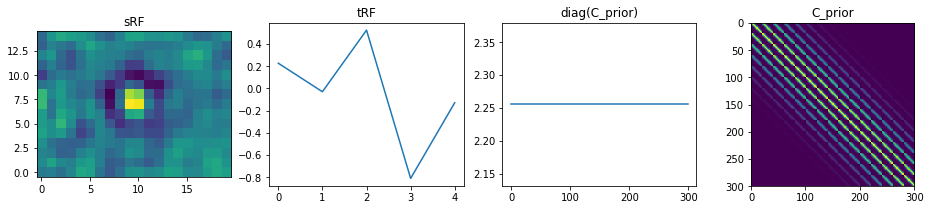

============3500============
sigma: 1.2568679273040428
rho: -0.7823877351990256
delta: 2.382711979968014
cost: 112.22516320000484


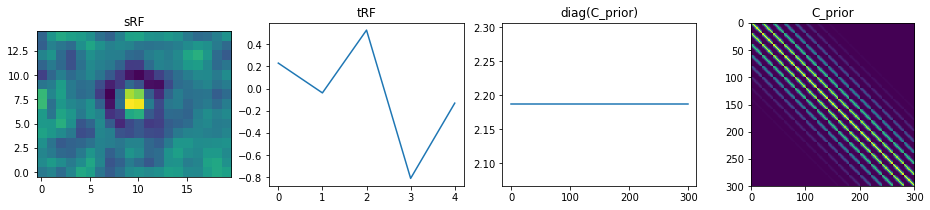

============4000============
sigma: 1.2350992686978277
rho: -0.773759525927332
delta: 2.3789393003286547
cost: 112.20304687979973


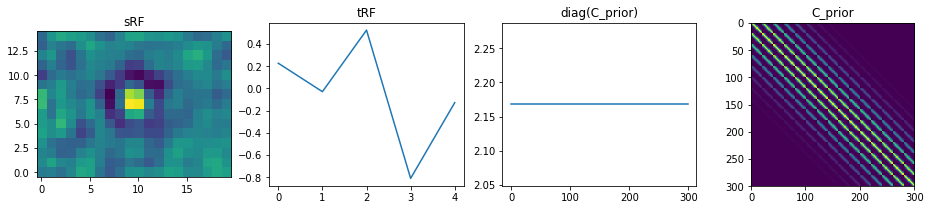

============4500============
sigma: 1.2339713306851174
rho: -0.7737590505093668
delta: 2.378942491179091
cost: 112.19850127195402


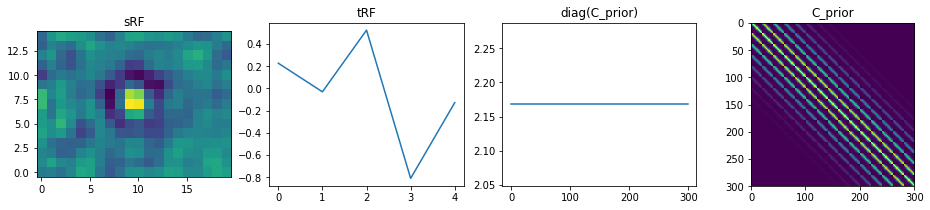

============Optimized============
sigma: 1.263992065930402
rho: -0.7735887417688827
delta: 2.3785786619146467
cost: 112.1574604797823


In [3]:
cost_list = []
import numpy as np
def callback(params, t, g):
    if t % 500 == 0:
        print('============{}============'.format(t))
        print('sigma: {0}'.format(params[0]))
        print('rho: {0}'.format(params[1]))
        print('delta: {0}'.format(params[2])) 
            
        (C_prior, 
         C_prior_inv) = opt.update_C_prior(params)
        
        (C_post, 
         C_post_inv, 
         m_post) = opt.update_posterior(params,
                                        C_prior,
                                        C_prior_inv)  
        
        cost = np.linalg.norm(opt.Y - get_sdm(opt.X, 5) @ m_post.reshape(np.product([*m_post.shape]), 1))
        cost_list.append(cost)
        print('cost: {0}'.format(cost))
        
        k,S,kt = randomized_svd(m_post, 3)
        
        fig, ax = plt.subplots(1,4, figsize=(16,3))
        
        ax[0].imshow(k[:, 0].reshape(15,20), origin='lower')
        ax[1].plot(kt[0])
        ax[2].plot(np.diag(C_prior))
        ax[3].imshow(C_prior)
        
        ax[0].set_title('sRF')
        ax[1].set_title('tRF')
        ax[2].set_title('diag(C_prior)')
        ax[3].set_title('C_prior')
        
        plt.show()
        
opt = rfest.ASD(X, Y, rf_dims=(15,20,5))

opt.fit(num_iters=5000,callback=callback)

print('============Optimized============')
opt_params = opt.optimized_params
print('sigma: {0}'.format(opt_params[0]))
print('rho: {0}'.format(opt_params[1]))
print('delta: {0}'.format(opt_params[2])) 
    
(C_prior, 
 C_prior_inv) = opt.update_C_prior(opt_params)

(C_post, 
 C_post_inv, 
 m_post) = opt.update_posterior(opt_params,
                                C_prior,
                                C_prior_inv)  

cost = np.linalg.norm(opt.Y - get_sdm(opt.X, 5) @ m_post.reshape(np.product([*m_post.shape]), 1))
cost_list.append(cost)
print('cost: {0}'.format(cost))

Text(0.5,1,'t_asd')

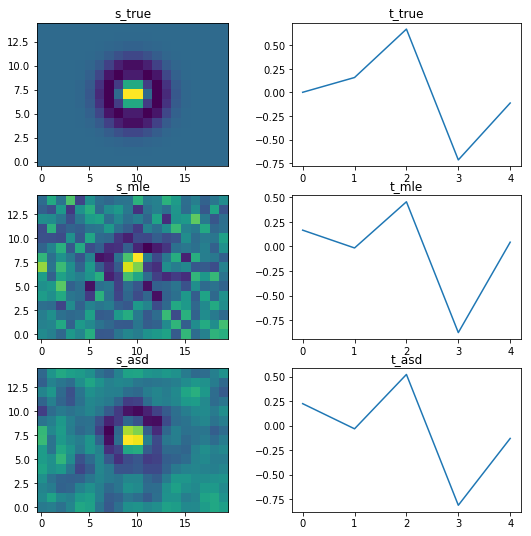

In [4]:
U_true, S, Vt_true = randomized_svd(w_true.reshape(300,5), 3)

fig, ax = plt.subplots(3,2, figsize=(9, 9))
ax[0, 0].imshow(U_true[:, 0].reshape(15, 20), origin='lower')
ax[0, 1].plot(Vt_true[0])

ax[1, 0].imshow(opt.sRF_mle, origin='lower')
ax[1, 1].plot(opt.tRF_mle)

ax[2, 0].imshow(opt.sRF_opt, origin='lower')
ax[2, 1].plot(opt.tRF_opt)


ax[0,0].set_title('s_true')
ax[0,1].set_title('t_true')

ax[1,0].set_title('s_mle')
ax[1,1].set_title('t_mle')

ax[2,0].set_title('s_asd')
ax[2,1].set_title('t_asd')

Text(0,0.5,'Prediction Error')

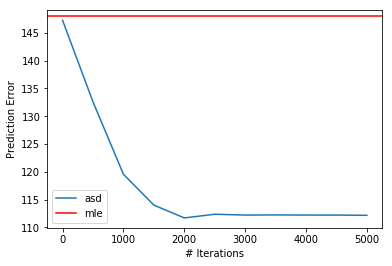

In [5]:
cost_mle = np.linalg.norm(opt.Y - get_sdm(opt.X, 5) @ opt.w_mle.reshape(np.product([*m_post.shape]), 1))

plt.plot(np.linspace(0, 5000, 11), cost_list, label='asd')
plt.axhline(cost_mle, color='red', label='mle')
plt.legend()
plt.xlabel('# Iterations')
plt.ylabel('Prediction Error')